## Environment and algrithms

### Highly random Normal bandit

In [ ]:
import numpy as np
def almost_equal(val1, val2):
    return 0.99 * val2 < val1 < 1.01 * val2

class NormalBandit_periodical:
    def __init__(self, num_arms=5, initial_means=None, variance_multiplier=1, change_interval=1, change_factor_mean=1):
        if initial_means is None:
            initial_means = np.random.rand(num_arms)
        self.num_arms = num_arms
        self.initial_means = np.copy(initial_means)
        self.all_means = [np.copy(initial_means)]
        self.variance_multiplier = variance_multiplier
        self.change_interval = change_interval
        self.change_factor_mean = change_factor_mean
        self.steps = 0

    def pull_arm(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm index")
        mean = self.all_means[-1][arm]
        #variance = (self.variance_multiplier * 1)
        #print(mean)
        variance = np.abs(self.variance_multiplier * mean)
        reward = np.random.normal(mean, np.sqrt(0.01*variance))
        self.step()
        return reward

    def step(self):
        self.steps += 1
        if np.random.choice([True, False], p=[0.005, 1 - 0.005]):
        #if self.steps % self.change_interval == 0:
            new_means = np.copy(self.initial_means)
            np.random.shuffle(new_means)
            for i in range(self.num_arms):
                #new_means[i] += np.random.normal(new_means[i], (self.variance_multiplier * 1)) * self.change_factor_mean
                new_means[i] += np.random.normal(0, (self.variance_multiplier)) * self.change_factor_mean

                new_means[i] = np.clip(new_means[i], -10, 10)
            np.random.shuffle(new_means)
            self.all_means.append(new_means)


    def reset(self):
        self.steps = 0
        self.all_means = [np.copy(self.initial_means)]

    # def generate_rewards(self, num_pulls):
    #     rewards = []
    #     for _ in range(num_pulls):
    #         arm = np.random.choice(self.num_arms)
    #         reward = self.pull_arm(arm)
    #         self.step()
    #         rewards.append(reward)
    #     return rewards



In [ ]:
import numpy as np
def almost_equal(val1, val2):
    return 0.999 * val2 < val1 < 1.001 * val2

class NormalBandit_prob:
    def __init__(self, num_arms=5, initial_means=None, variance_multiplier=1, change_prob=0, change_factor_mean=1):
        if initial_means is None:
            initial_means = np.random.rand(num_arms)
        self.num_arms = num_arms
        self.initial_means = np.copy(initial_means)
        self.all_means = [np.copy(initial_means)]
        self.variance_multiplier = variance_multiplier
        self.change_prob = change_prob
        self.change_factor_mean = change_factor_mean
        self.steps = 0
        self.changes = 0
    def pull_arm(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm index")
        mean = self.all_means[-1][arm]
        #variance = (self.variance_multiplier * 1)
        #print(mean)
        variance = np.abs(self.variance_multiplier * mean)
        reward = np.random.normal(mean, np.sqrt(0.01*variance))
        self.step()
        return reward

    def step(self):
        self.steps += 1
        if np.random.choice([True, False], p=[self.change_prob, 1 - self.change_prob]):
        #if self.steps % self.change_interval == 0:
            new_means = np.copy(self.initial_means)
            np.random.shuffle(new_means)
            for i in range(self.num_arms):
                #new_means[i] += np.random.normal(new_means[i], (self.variance_multiplier * 1)) * self.change_factor_mean
                new_means[i] += np.random.normal(0, (self.variance_multiplier)) * self.change_factor_mean

                new_means[i] = np.clip(new_means[i], -10, 10)
            np.random.shuffle(new_means)
            self.all_means.append(new_means)
            #print("changed")
            self.changes+=1
            #print(self.changes)

    def reset(self):
        self.steps = 0
        self.changes = 0
        self.all_means = [np.copy(self.initial_means)]

    # def generate_rewards(self, num_pulls):
    #     rewards = []
    #     for _ in range(num_pulls):
    #         arm = np.random.choice(self.num_arms)
    #         reward = self.pull_arm(arm)
    #         self.step()
    #         rewards.append(reward)
    #     return rewards


### epsilon Greedy

In [ ]:
import numpy as np

def epsilon_greedy(bandit, epsilon, alpha=None, num_time_step=1000):
    """Epsilon greedy algorithm for bandit action selection

    Parameters
    ----------
    bandit : NormalBandit object
        An instance of the NormalBandit class
    epsilon : float
        A parameter which determines the probability for a random action to be selected
    alpha : float, optional
        A parameter which determines the learning rate for averaging. If alpha is None, incremental averaging is used.
        Default is None, corresponding to incremental averaging.
    num_time_step : int, optional
        The number of time steps to run the algorithm
        Default is 1000

    Returns
    -------
    R_over_t : list
        A list of instantaneous return over the time steps
    total_R_over_t : list
        A list of cumulative reward over the time steps
    est_is_best_over_t : list
        A list of values of 0 and 1 where 1 indicates the estimated best action is the true best action and 0 otherwise for each time step
    l_over_t : list
        A list of instantaneous regret over the time steps
    total_l_over_t : list
        A list of cumulative regret over the time steps
    """
    bandit.reset()
    num_arms = bandit.num_arms
    Q_arr = np.zeros(num_arms)  # array of estimated average reward for each action
    N_arr = np.zeros(num_arms)  # array of number of times picked for each action
    total_R = 0
    total_l = 0
    actions = range(num_arms)
    opt_value = np.max(bandit.initial_means)  # highest expected reward among all actions
    R_over_t = []
    total_R_over_t = []
    est_is_best_over_t = []
    l_over_t = []
    total_l_over_t = []

    for time_step in range(num_time_step):

        opt_value = np.max(bandit.all_means[-1])  # Optimal value for calculating regret
        best_action = []  # The best action based on bandit means

        for a in range(num_arms):
          if almost_equal(bandit.all_means[-1][a],opt_value):
            best_action.append(a)

        A_star = np.random.choice(np.flatnonzero(Q_arr == np.max(Q_arr)))  # get action with highest estimated average reward with random tie-breaking
        A_random = np.random.choice(num_arms)
        A = np.random.choice([A_random, A_star], p=[epsilon, 1 - epsilon])  # pick a random action with probability epsilon
        curr_R = bandit.pull_arm(A)
        N_arr[A] = N_arr[A] + 1

        if alpha is None:
            Q_arr[A] += (curr_R - Q_arr[A]) / N_arr[A]
        else:
            Q_arr[A] += alpha * (curr_R - Q_arr[A])

        R_over_t.append(curr_R)

        total_R = total_R + curr_R
        total_R_over_t.append(total_R)

        est_is_best = 1 if A in best_action else 0

        est_is_best_over_t.append(est_is_best)

        l_t = opt_value - bandit.initial_means[A]
        l_over_t.append(l_t)

        total_l = total_l + l_t
        total_l_over_t.append(total_l)
    #print(np.mean(bandit.all_means , axis = 1))
    return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Improved UCB

#### c increase and decrease by c_update_scale reset = False
#### c decrease by c_update_scale and reset if it need to increase reset = True

In [ ]:
import numpy as np


def UCB_Learnlr(bandit, c=1, alpha=0.1, num_time_step=5000 , c_update_scale = 0.01, reset = False):
    bandit.reset()
    num_arms = bandit.num_arms
    Q_arr = np.zeros(num_arms)  # Estimated value of each action
    N_arr = np.zeros(num_arms) + 1e-5  # Number of times each action has been chosen, initialized to a small number to avoid division by zero
    total_R = 0
    total_l = 0
    c_val = c
    R_over_t = []
    total_R_over_t = []
    est_is_best_over_t = []
    l_over_t = []
    total_l_over_t = []
    c_arr = []


    for t in range(num_time_step):
        opt_value = np.max(bandit.all_means[-1])  # Optimal value for calculating regret
        best_action = []  # The best action based on bandit means

        for a in range(num_arms):
          if almost_equal(bandit.all_means[-1][a],opt_value):
            best_action.append(a)
        if 0 in N_arr:
            A = np.random.choice(np.where(N_arr == 0)[0])  # Play each arm at least once
        else:
            UCB_values = Q_arr + c * np.sqrt(np.log(t + 1) / N_arr)
            A = np.argmax(UCB_values)

        curr_R = bandit.pull_arm(A)
        N_arr[A] += 1

        upper_bounds = Q_arr + c * np.sqrt(np.log(t + 1) / N_arr)
        lower_bounds = Q_arr - c * np.sqrt(np.log(t + 1) / N_arr)
        if alpha is None:
            # incremental averaging
            Q_arr[A] = Q_arr[A] + (curr_R - Q_arr[A]) / N_arr[A]
        else:
            Q_arr[A] = Q_arr[A] + (alpha * (curr_R - Q_arr[A]))
        # Record the reward and regret
        R_over_t.append(curr_R)
        total_R += curr_R
        total_R_over_t.append(total_R)
        est_is_best = int(A in best_action)
        est_is_best_over_t.append(est_is_best)
        l_t = opt_value - bandit.all_means[-1][A]
        l_over_t.append(l_t)
        total_l += l_t
        total_l_over_t.append(total_l)

        # Adjust exploration rate alpha based on reward and confidence interval
        if curr_R >= lower_bounds[A] and curr_R <= upper_bounds[A]:
          c *= (1-c_update_scale)  # Decrease alpha to slow down exploration if reward falls within CI
        else :
          if reset:
            c = c_val
          else:
            c *= (1+c_update_scale)
        c_arr.append(c)
    #print(c)
    #print(np.mean(bandit.all_means , axis = 1))
    return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr

### bandits, agent setup

In [ ]:
bandits = []
# bandits.append(NormalBandit_periodical(initial_means=[0.1, 0.3, 0.5, 0.7, 0.9],variance_multiplier=1,change_factor_mean=1,change_interval=100))
# bandits.append(NormalBandit_periodical(initial_means=[0.1, 0.3, 0.5, 0.7, 0.9],variance_multiplier=5,change_factor_mean=1,change_interval=100))
# bandits.append(NormalBandit_periodical(initial_means=[0.1, 0.3, 0.5, 0.7, 0.9],variance_multiplier=1,change_factor_mean=5,change_interval=100))
# bandits.append(NormalBandit_periodical(initial_means=[0.1, 0.3, 0.5, 0.7, 0.9],variance_multiplier=1,change_factor_mean=1,change_interval=50))


In [ ]:
bandits.append(NormalBandit_prob(initial_means=[0.1, 0.3, 0.5, 0.7, 0.9],variance_multiplier=1,change_factor_mean=1,change_prob=0))
bandits.append(NormalBandit_prob(initial_means=[0.1, 0.3, 0.5, 0.7, 0.9],variance_multiplier=1,change_factor_mean=1,change_prob=0.005))
bandits.append(NormalBandit_prob(initial_means=[0.1, 0.3, 0.5, 0.7, 0.9],variance_multiplier=5,change_factor_mean=1,change_prob=0.005))
bandits.append(NormalBandit_prob(initial_means=[0.1, 0.3, 0.5, 0.7, 0.9],variance_multiplier=1,change_factor_mean=5,change_prob=0.005))
bandits.append(NormalBandit_prob(initial_means=[0.1, 0.3, 0.5, 0.7, 0.9],variance_multiplier=1,change_factor_mean=1,change_prob=0.025))

## Experiment

### Getting data base on algrithm (to get best config)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#test config ranges
epsilon_values = [1/4,1/8,1/16]
alpha_values = [0.05,0.2,0.1,None]
c_values = [1/8,1/2,1,2]
experiment_ecops = 100



num_time_step = 1000
# mannually judged from plots as any average may have trouble


all_EG_result = []
all_UCB_ORI_result = []
all_UCB_IMP_result = []

best_C_alter_IMP_UCB = []


for bandit_I in range(len(bandits)):
  print(bandit_I)
  curr_bandit = bandits[bandit_I]
  epsilon_greedy_results = {}
  ucb_results = {}
  ucb_IMP_results = {}
# Run experiments for each combination of epsilon and alpha for epsilon-greedy
  for epsilon in epsilon_values:
    for alpha in alpha_values:
      vals = []
      for epoch in range(experiment_ecops):
        R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = epsilon_greedy(curr_bandit, epsilon, alpha, num_time_step)
        vals.append((R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t))
      epsilon_greedy_results[(epsilon, alpha)] = vals

  # Run experiments for trad UCB algorithm
  for c in c_values:
    for alpha in alpha_values:
      vals = []
      for epoch in range(experiment_ecops):
        R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = UCB_Learnlr(curr_bandit, c,alpha=alpha, num_time_step=num_time_step,c_update_scale=0,reset=False)
        vals.append((R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr))
      ucb_results[(c, alpha)] = vals


  all_EG_result.append(epsilon_greedy_results)
  all_UCB_ORI_result.append(ucb_results)




0
1
2
3
4


### picking best epsilon greedy for each environment

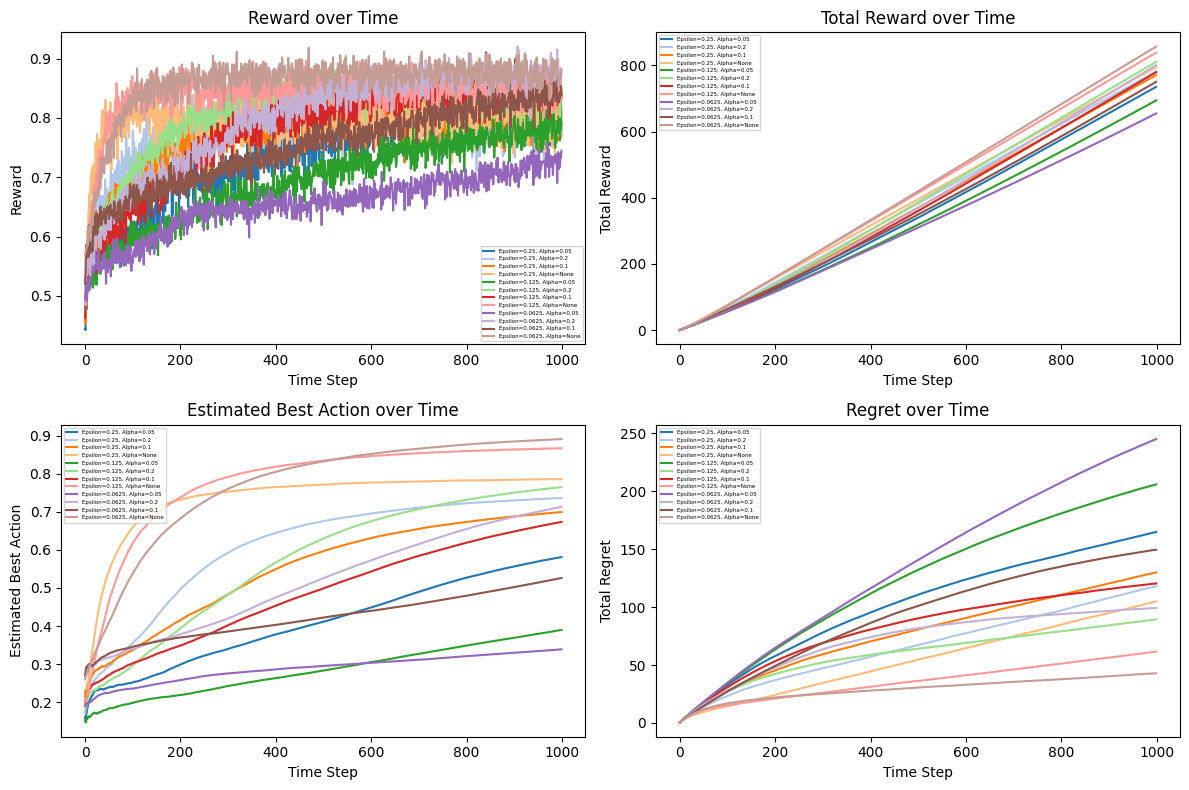

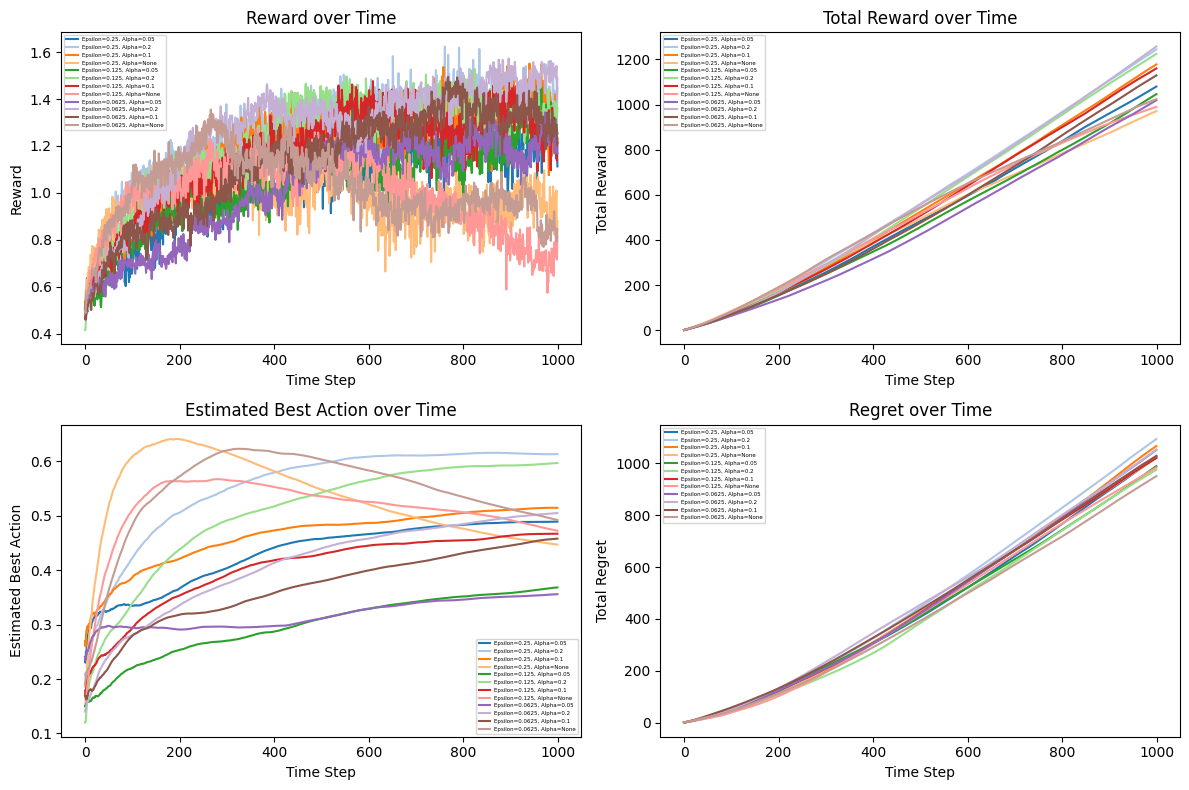

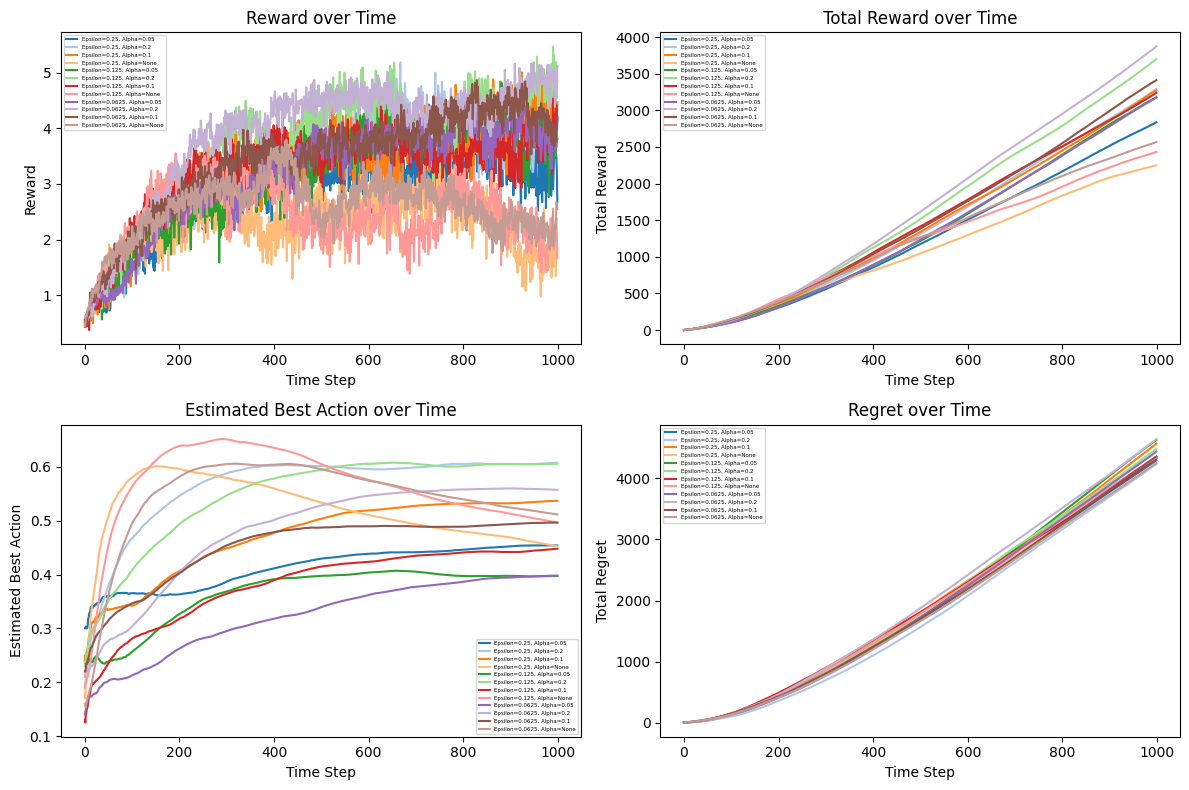

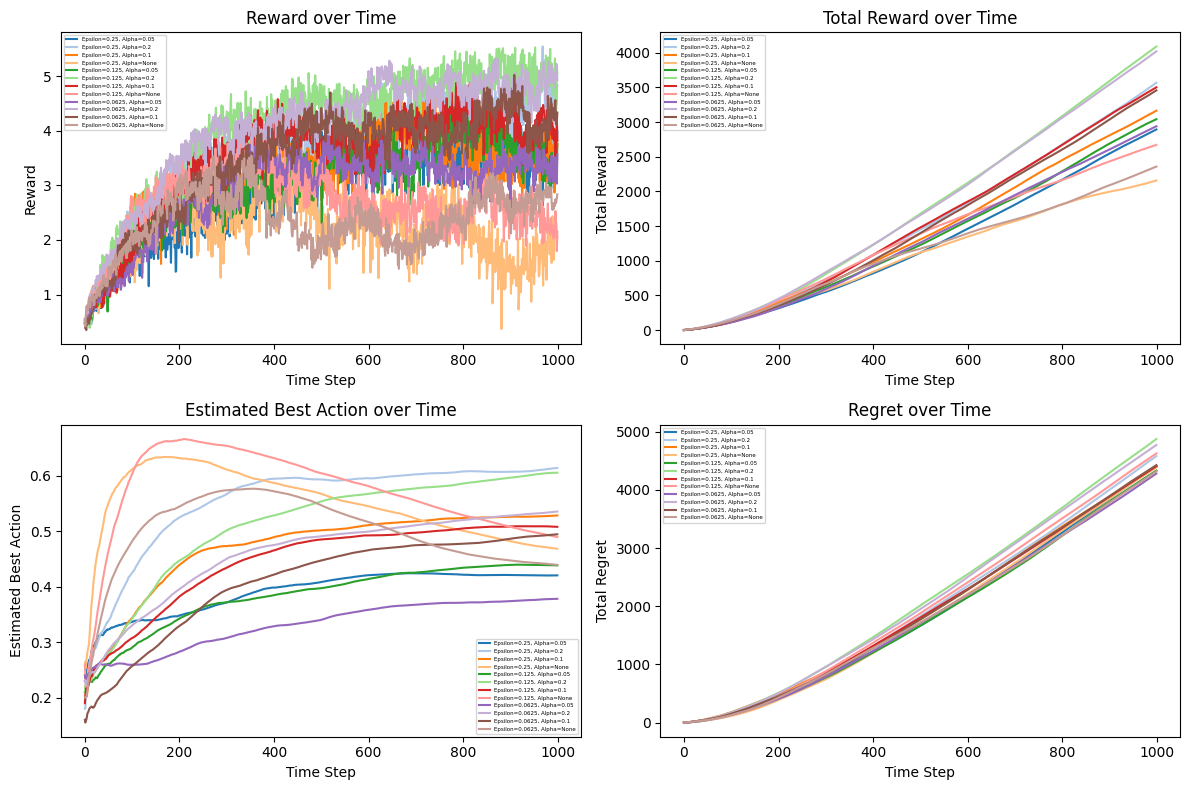

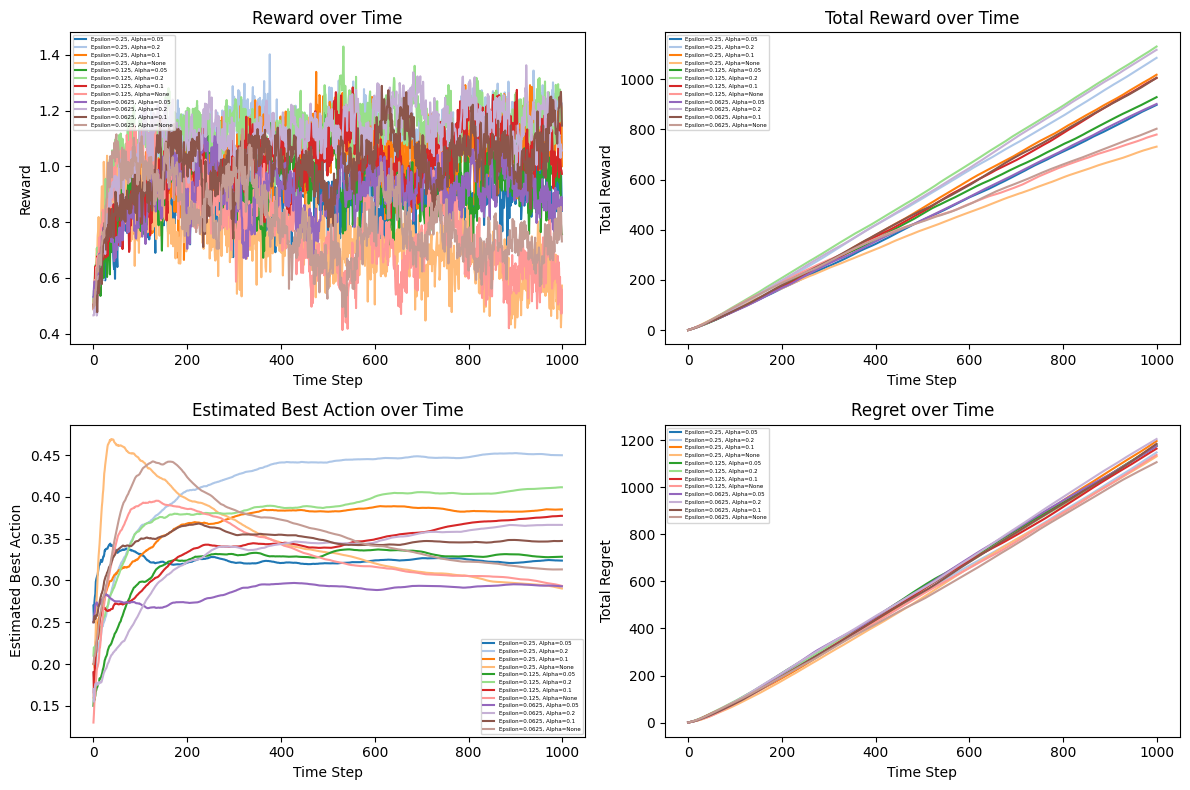

In [ ]:
for bandit_I in range(len(bandits)):
  #print(str(bandit_I) + "th bandit")
  plt.figure(figsize=(12, 8))
  results = all_EG_result[bandit_I]
  colors = plt.cm.tab20.colors[:20]
  for i, (epsilon, alpha) in enumerate(results.keys()):
    vals = results[(epsilon, alpha)]
    #print(len(vals))
    R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = vals[0]
    #print(np.array(R_over_t).shape)
    for ecops in range(1,experiment_ecops):
      R_over_t_temp, total_R_over_t_temp, est_is_best_over_t_temp, l_over_t_temp, total_l_over_t_temp = vals[ecops]
      R_over_t = np.array(R_over_t)
      R_over_t += np.array(R_over_t_temp)
      total_R_over_t = np.array(total_R_over_t)
      total_R_over_t += np.array(total_R_over_t_temp)
      est_is_best_over_t = np.array(est_is_best_over_t)
      est_is_best_over_t += np.array(est_is_best_over_t_temp)
      l_over_t = np.array(l_over_t)
      l_over_t += np.array(l_over_t_temp)
      total_l_over_t = np.array(total_l_over_t)
      total_l_over_t += np.array(total_l_over_t_temp)
    #print(R_over_t)
    R_over_t = R_over_t/experiment_ecops
    total_R_over_t = total_R_over_t/experiment_ecops
    est_is_best_over_t = est_is_best_over_t/experiment_ecops
    l_over_t = l_over_t/experiment_ecops
    total_l_over_t = total_l_over_t/experiment_ecops
    # Plot reward over time
    plt.subplot(2, 2, 1)
    plt.plot(R_over_t,color=colors[i],  label=f"Epsilon={epsilon}, Alpha={alpha}")
    plt.title('Reward over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Reward')
    plt.legend(fontsize=4)

    # Plot total reward over time
    plt.subplot(2, 2, 2)
    plt.plot(total_R_over_t,color=colors[i],  label=f"Epsilon={epsilon}, Alpha={alpha}")
    plt.title('Total Reward over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Total Reward')
    plt.legend(fontsize=4)

    # Plot estimated best action over time
    plt.subplot(2, 2, 3)
    betactp = np.cumsum(est_is_best_over_t) / np.arange(1, num_time_step + 1)
    plt.plot(betactp,color=colors[i],  label=f"Epsilon={epsilon}, Alpha={alpha}")
    plt.title('Estimated Best Action over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Estimated Best Action')
    plt.legend(fontsize=4)

    # Plot regret over time
    plt.subplot(2, 2, 4)
    plt.plot(total_l_over_t,color=colors[i],  label=f"Epsilon={epsilon}, Alpha={alpha}")
    plt.title('Regret over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Total Regret')
    plt.legend(fontsize=4)

  plt.tight_layout()
  plt.show()

### picking best UCB for each environment

0th bandit


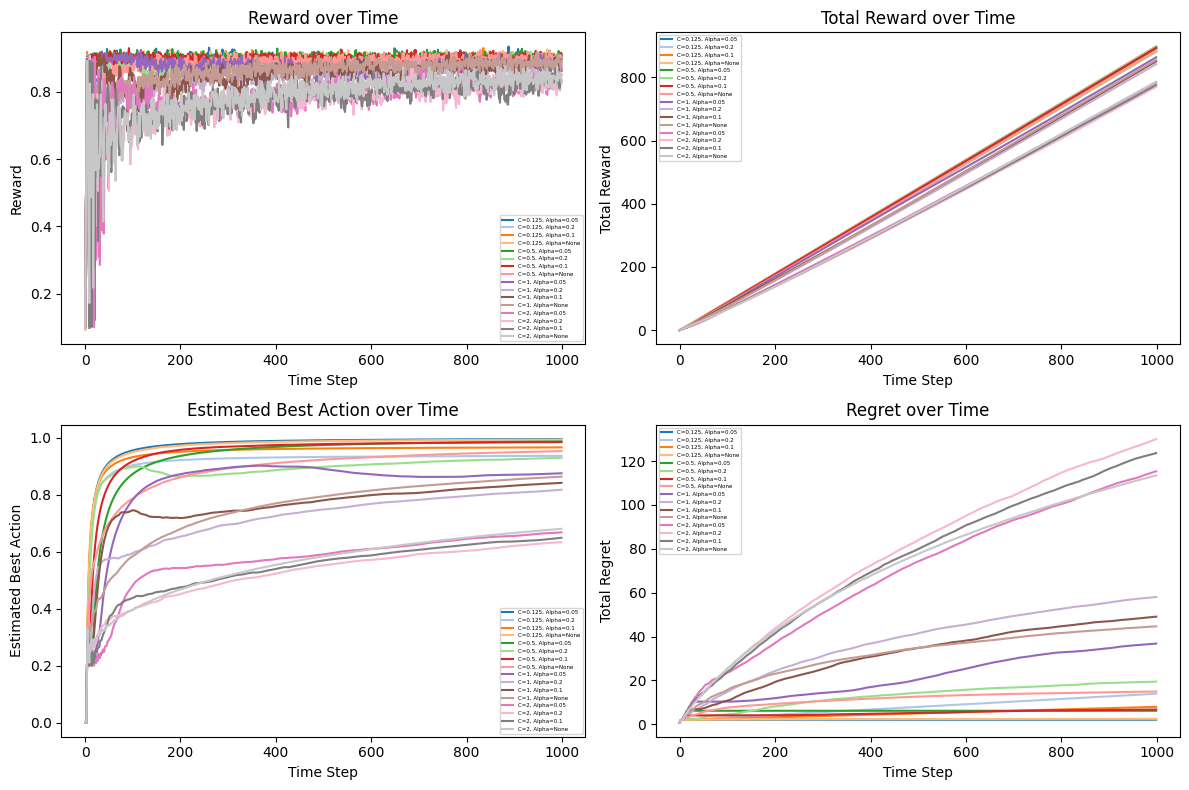

1th bandit


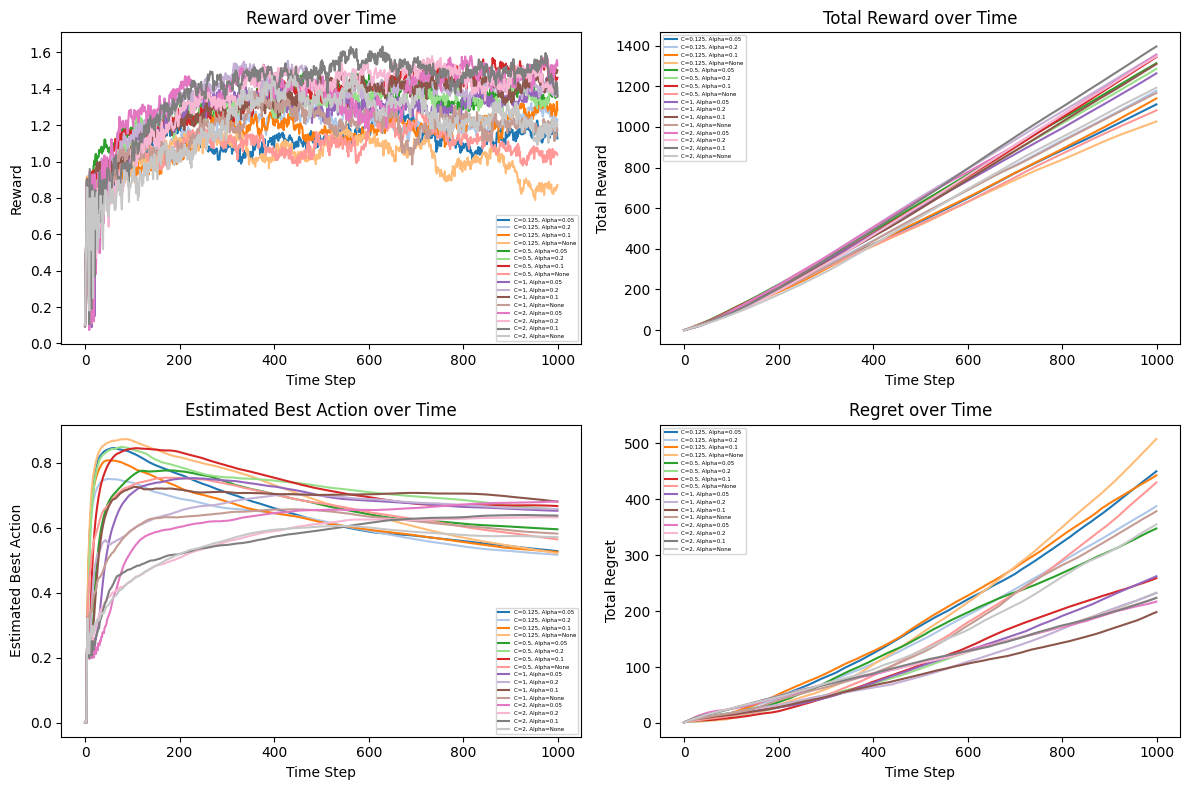

2th bandit


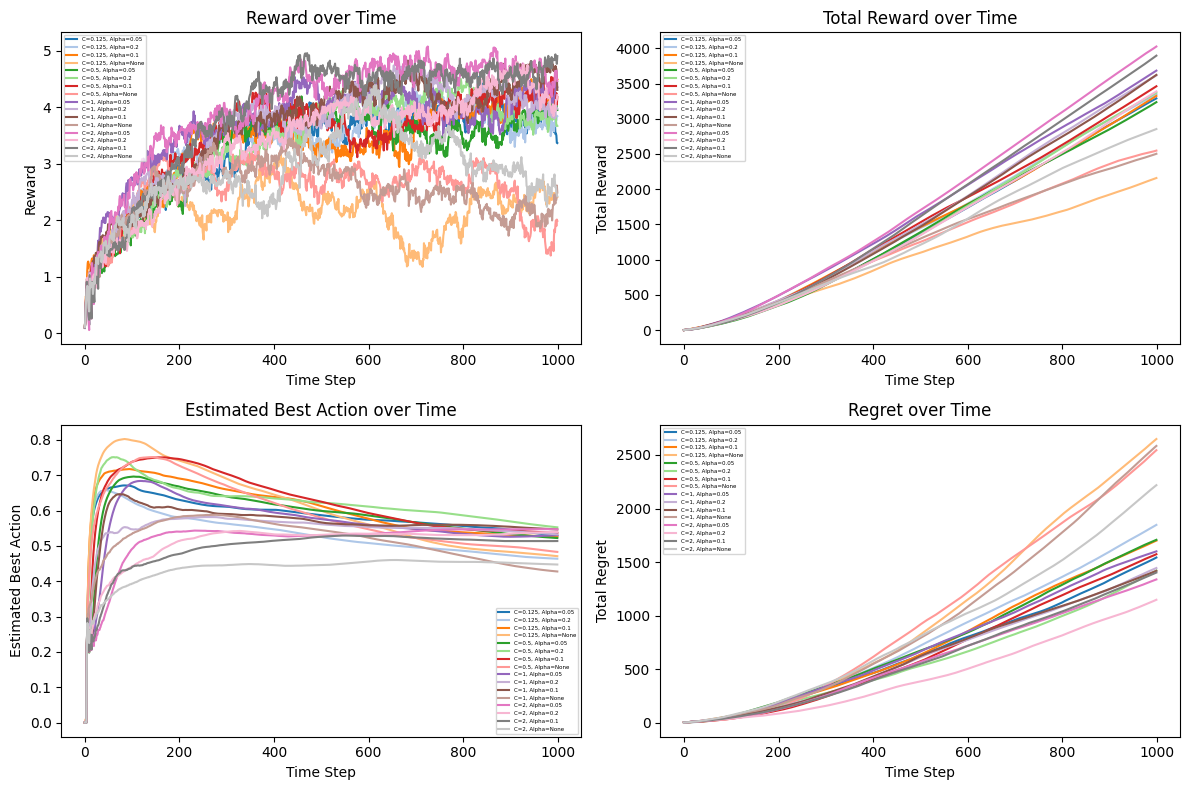

3th bandit


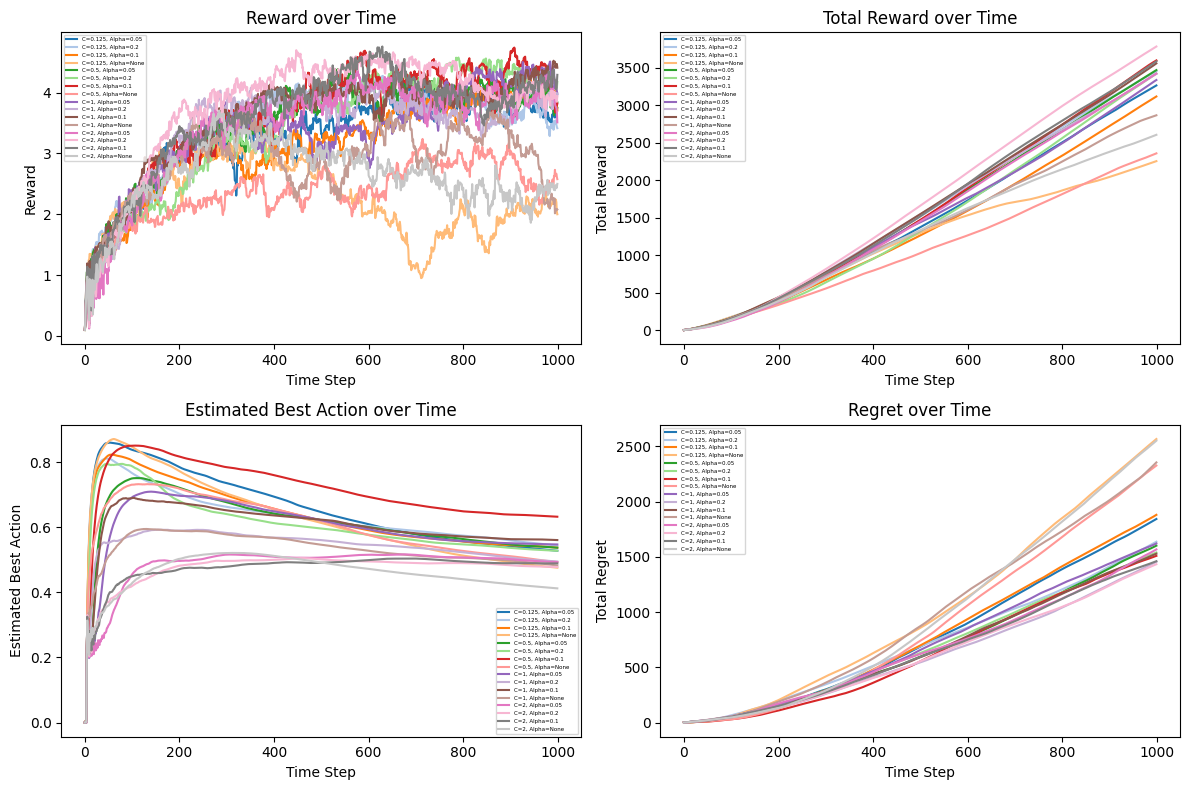

4th bandit


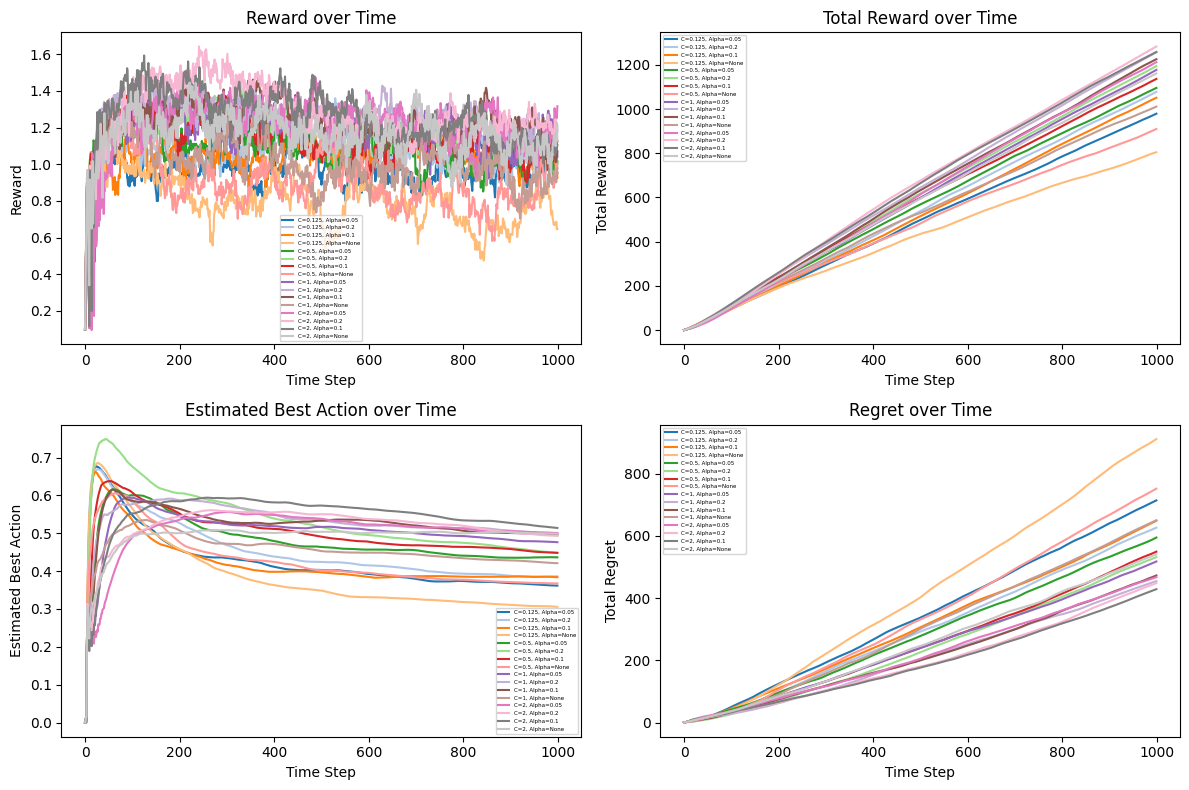

In [ ]:
for bandit_I in range(len(bandits)):
  print(str(bandit_I) + "th bandit")
  plt.figure(figsize=(12, 8))
  results = all_UCB_ORI_result[bandit_I]
  colors = plt.cm.tab20.colors[:20]
  for i, (c, alpha) in enumerate(results.keys()):
    vals = results[(c, alpha)]
    #print(len(vals))
    R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = vals[0]
    #print(np.array(R_over_t).shape)
    for ecops in range(1,experiment_ecops):
      R_over_t_temp, total_R_over_t_temp, est_is_best_over_t_temp, l_over_t_temp, total_l_over_t_temp,c_arr = vals[ecops]
      R_over_t = np.array(R_over_t)
      R_over_t += np.array(R_over_t_temp)
      total_R_over_t = np.array(total_R_over_t)
      total_R_over_t += np.array(total_R_over_t_temp)
      est_is_best_over_t = np.array(est_is_best_over_t)
      est_is_best_over_t += np.array(est_is_best_over_t_temp)
      l_over_t = np.array(l_over_t)
      l_over_t += np.array(l_over_t_temp)
      total_l_over_t = np.array(total_l_over_t)
      total_l_over_t += np.array(total_l_over_t_temp)
    #print(R_over_t)
    R_over_t = R_over_t/experiment_ecops
    total_R_over_t = total_R_over_t/experiment_ecops
    est_is_best_over_t = est_is_best_over_t/experiment_ecops
    l_over_t = l_over_t/experiment_ecops
    total_l_over_t = total_l_over_t/experiment_ecops
    # Plot reward over time
    plt.subplot(2, 2, 1)
    plt.plot(R_over_t,color=colors[i], label=f"C={c}, Alpha={alpha}")
    plt.title('Reward over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Reward')
    plt.legend(fontsize=4)

    # Plot total reward over time
    plt.subplot(2, 2, 2)
    plt.plot(total_R_over_t,color=colors[i], label=f"C={c}, Alpha={alpha}")
    plt.title('Total Reward over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Total Reward')
    plt.legend(fontsize=4)

    # Plot estimated best action over time
    plt.subplot(2, 2, 3)
    betactp = np.cumsum(est_is_best_over_t) / np.arange(1, num_time_step + 1)
    plt.plot(betactp,color=colors[i], label=f"C={c}, Alpha={alpha}")
    plt.title('Estimated Best Action over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Estimated Best Action')
    plt.legend(fontsize=4)

    # Plot regret over time
    plt.subplot(2, 2, 4)
    plt.plot(total_l_over_t,color=colors[i], label=f"C={c}, Alpha={alpha}")
    plt.title('Regret over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Total Regret')
    plt.legend(fontsize=4)

  plt.tight_layout()
  plt.show()

### explore how c_changomg rate affect performance

In [ ]:
best_C_UCB = [1/8,1,0.5,0.5,2]
best_alpha_UCB = [0.05,0.05,0.1,0.05,0.2]
c_alter_values = [1/2,1/4,1/8,1/16,1/32,0]
all_UCB_ORI_result_best = []
all_UCB_IMP_result_best_reset = []
all_UCB_IMP_result_best_Not_reset = []
#num_change = np.zeros(4,6)
for bandit_I in range(len(bandits)):
  print(bandit_I)
  curr_bandit = bandits[bandit_I]

  ucb_IMP_results1 = {}

  # Run experiments for UCB algorithm
  index = 0
  for c_a in c_alter_values:
    vals = []
    for epoch in range(experiment_ecops):
      R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = UCB_Learnlr(curr_bandit, c=best_C_UCB[bandit_I],alpha=best_alpha_UCB[bandit_I], num_time_step=num_time_step,c_update_scale=c_alter_values[index],reset=True)
      vals.append((R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr))
    ucb_IMP_results1[(c_a)] = vals
    index+=1
  all_UCB_IMP_result_best_reset.append(ucb_IMP_results1)

  ucb_IMP_results2 = {}
  index = 0
  for c_a in c_alter_values:
    vals = []
    for epoch in range(experiment_ecops):
      R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = UCB_Learnlr(curr_bandit, c=best_C_UCB[bandit_I],alpha=best_alpha_UCB[bandit_I], num_time_step=num_time_step,c_update_scale=c_alter_values[index],reset=False)
      vals.append((R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr))
    ucb_IMP_results2[(c_a)] = vals
    index+=1
  all_UCB_IMP_result_best_Not_reset.append(ucb_IMP_results2)




0


KeyboardInterrupt: 

### check the effect of c_change_factor, with Reset or not reset on improved UCB using trad UCB config performance gives best performance

#### Reset

In [ ]:
for bandit_I in range(len(bandits)):
  print(str(bandit_I) + "th bandit")
  plt.figure(figsize=(12, 8))
  results = all_UCB_IMP_result_best_reset[bandit_I]
  colors = plt.cm.tab20.colors[:20]
  for i, (c_a) in enumerate(results.keys()):
    vals = results[(c_a)]
    #print(len(vals))
    R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = vals[0]
    #print(np.array(R_over_t).shape)
    for ecops in range(1,experiment_ecops):
      R_over_t_temp, total_R_over_t_temp, est_is_best_over_t_temp, l_over_t_temp, total_l_over_t_temp,c_arr_temp = vals[ecops]
      R_over_t = np.array(R_over_t)
      R_over_t += np.array(R_over_t_temp)
      total_R_over_t = np.array(total_R_over_t)
      total_R_over_t += np.array(total_R_over_t_temp)
      est_is_best_over_t = np.array(est_is_best_over_t)
      est_is_best_over_t += np.array(est_is_best_over_t_temp)
      l_over_t = np.array(l_over_t)
      l_over_t += np.array(l_over_t_temp)
      total_l_over_t = np.array(total_l_over_t)
      total_l_over_t += np.array(total_l_over_t_temp)
      c_arr = np.array(c_arr)
      c_arr += np.array(c_arr_temp)
    #print(R_over_t)
    R_over_t = R_over_t/experiment_ecops
    total_R_over_t = total_R_over_t/experiment_ecops
    est_is_best_over_t = est_is_best_over_t/experiment_ecops
    l_over_t = l_over_t/experiment_ecops
    total_l_over_t = total_l_over_t/experiment_ecops
    c_arr = c_arr/experiment_ecops
    # Plot reward over time
    plt.subplot(2, 3, 1)
    plt.plot(R_over_t,color=colors[i], label=f"C_alter={c_a}")
    plt.title('Reward over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Reward')
    plt.legend(fontsize=4)

    # Plot total reward over time
    plt.subplot(2, 3, 2)
    plt.plot(total_R_over_t,color=colors[i], label=f"C_alter={c_a}")
    plt.title('Total Reward over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Total Reward')
    plt.legend(fontsize=4)

    # Plot estimated best action over time
    plt.subplot(2, 3, 3)
    betactp = np.cumsum(est_is_best_over_t) / np.arange(1, num_time_step + 1)
    plt.plot(betactp,color=colors[i], label=f"C_alter={c_a}")
    plt.title('Estimated Best Action over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Estimated Best Action')
    plt.legend(fontsize=4)

    # Plot regret over time
    plt.subplot(2, 3, 4)
    plt.plot(total_l_over_t,color=colors[i], label=f"C_alter={c_a}")
    plt.title('Regret over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Total Regret')
    plt.legend(fontsize=4)


    # Plot regret over time
    plt.subplot(2, 3, 5)
    plt.plot(c_arr,color=colors[i], label=f"C_alter={c_a}")
    plt.title('C_val over Time')
    plt.xlabel('Time Step')
    plt.ylabel('C at t')
    plt.legend(fontsize=4)

  plt.tight_layout()
  plt.show()

#### Not reset

In [ ]:
for bandit_I in range(len(bandits)):
  print(str(bandit_I) + "th bandit")
  plt.figure(figsize=(12, 8))
  results = all_UCB_IMP_result_best_Not_reset[bandit_I]
  colors = plt.cm.tab20.colors[:20]
  for i, (c_a) in enumerate(results.keys()):
    vals = results[(c_a)]
    #print(len(vals))
    R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = vals[0]
    #print(np.array(R_over_t).shape)
    for ecops in range(1,experiment_ecops):
      R_over_t_temp, total_R_over_t_temp, est_is_best_over_t_temp, l_over_t_temp, total_l_over_t_temp,c_arr_temp = vals[ecops]
      R_over_t = np.array(R_over_t)
      R_over_t += np.array(R_over_t_temp)
      total_R_over_t = np.array(total_R_over_t)
      total_R_over_t += np.array(total_R_over_t_temp)
      est_is_best_over_t = np.array(est_is_best_over_t)
      est_is_best_over_t += np.array(est_is_best_over_t_temp)
      l_over_t = np.array(l_over_t)
      l_over_t += np.array(l_over_t_temp)
      total_l_over_t = np.array(total_l_over_t)
      total_l_over_t += np.array(total_l_over_t_temp)
      c_arr = np.array(c_arr)
      c_arr += np.array(c_arr_temp)
    #print(R_over_t)
    R_over_t = R_over_t/experiment_ecops
    total_R_over_t = total_R_over_t/experiment_ecops
    est_is_best_over_t = est_is_best_over_t/experiment_ecops
    l_over_t = l_over_t/experiment_ecops
    total_l_over_t = total_l_over_t/experiment_ecops
    c_arr = c_arr/experiment_ecops
    # Plot reward over time
    plt.subplot(2, 3, 1)
    plt.plot(R_over_t,color=colors[i], label=f"C_alter={c_a}")
    plt.title('Reward over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Reward')
    plt.legend(fontsize=4)

    # Plot total reward over time
    plt.subplot(2, 3, 2)
    plt.plot(total_R_over_t,color=colors[i], label=f"C_alter={c_a}")
    plt.title('Total Reward over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Total Reward')
    plt.legend(fontsize=4)

    # Plot estimated best action over time
    plt.subplot(2, 3, 3)
    betactp = np.cumsum(est_is_best_over_t) / np.arange(1, num_time_step + 1)
    plt.plot(betactp,color=colors[i], label=f"C_alter={c_a}")
    plt.title('Estimated Best Action over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Estimated Best Action')
    plt.legend(fontsize=4)

    # Plot regret over time
    plt.subplot(2, 3, 4)
    plt.plot(total_l_over_t,color=colors[i], label=f"C_alter={c_a}")
    plt.title('Regret over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Total Regret')
    plt.legend(fontsize=4)

    # Plot regret over time
    plt.subplot(2, 3, 5)
    plt.plot(c_arr,color=colors[i], label=f"C_alter={c_a}")
    plt.title('C_val over Time')
    plt.xlabel('Time Step')
    plt.ylabel('C at t')
    plt.legend(fontsize=4)

  plt.tight_layout()
  plt.show()

### Find Best Config for improved  UCB for each environment

In [ ]:
C_s = [1/8,1/2,1,2]
alpha_values = [0.05,0.2,0.1,None]
c_alter_values = [1/2,1/4,1/8,0]
all_UCB_ORI_result_best = []
all_UCB_IMP_result_best_reset_allc = []
all_UCB_IMP_result_best_Not_reset_allc = []




for bandit_I in range(len(bandits)):
  print(bandit_I)
  curr_bandit = bandits[bandit_I]

  ucb_IMP_results1 = {}
  for c_s in C_s:
    for a_s in alpha_values:
      for c_a in c_alter_values:
        vals = []
        for epoch in range(experiment_ecops):
          R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = \
            UCB_Learnlr(curr_bandit, c=c_s,alpha=a_s, num_time_step=num_time_step,c_update_scale=c_a,reset=True)
          vals.append((R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr))
        ucb_IMP_results1[(c_s,a_s,c_a)] = vals
  all_UCB_IMP_result_best_reset_allc.append(ucb_IMP_results1)

  ucb_IMP_results2 = {}
  for c_s in C_s:
    for a_s in alpha_values:
      for c_a in c_alter_values:
        vals = []
        for epoch in range(experiment_ecops):
          R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = \
            UCB_Learnlr(curr_bandit, c=c_s,alpha=a_s, num_time_step=num_time_step,c_update_scale=c_a,reset=False)
          vals.append((R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr))
        ucb_IMP_results2[(c_s,a_s,c_a)] = vals
  all_UCB_IMP_result_best_Not_reset_allc.append(ucb_IMP_results2)


In [ ]:
import json


# File path to store the JSON data
file_path = "data.json"

# Writing data to JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file)

print("Data stored in JSON successfully!")

### Plot the performance of all Improved UCB config

In [ ]:
for bandit_I in range(len(bandits)):
  print(str(bandit_I) + "th bandit")


  results = all_UCB_IMP_result_best_reset_allc[bandit_I]
  colors = plt.cm.tab20.colors[:30]

  for a_S in alpha_values:
    inde=0
    plt.figure(figsize=(12, 8))
    for i, (c_s,a_s,c_a) in enumerate(results.keys()):
      if a_S == a_s:

        vals = results[(c_s,a_s,c_a)]
        #print(len(vals))
        R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = vals[0]
        #print(np.array(R_over_t).shape)
        for ecops in range(1,experiment_ecops):
          R_over_t_temp, total_R_over_t_temp, est_is_best_over_t_temp, l_over_t_temp, total_l_over_t_temp,c_arr_temp = vals[ecops]
          R_over_t = np.array(R_over_t)
          R_over_t += np.array(R_over_t_temp)
          total_R_over_t = np.array(total_R_over_t)
          total_R_over_t += np.array(total_R_over_t_temp)
          est_is_best_over_t = np.array(est_is_best_over_t)
          est_is_best_over_t += np.array(est_is_best_over_t_temp)
          l_over_t = np.array(l_over_t)
          l_over_t += np.array(l_over_t_temp)
          total_l_over_t = np.array(total_l_over_t)
          total_l_over_t += np.array(total_l_over_t_temp)
          c_arr = np.array(c_arr)
          c_arr += np.array(c_arr_temp)
        #print(R_over_t)
        R_over_t = R_over_t/experiment_ecops
        total_R_over_t = total_R_over_t/experiment_ecops
        est_is_best_over_t = est_is_best_over_t/experiment_ecops
        l_over_t = l_over_t/experiment_ecops
        total_l_over_t = total_l_over_t/experiment_ecops
        c_arr = c_arr/experiment_ecops
        # Plot reward over time
        plt.subplot(2, 3, 1)
        plt.plot(R_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Reward over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Reward')
        plt.legend(fontsize=4)

        # Plot total reward over time
        plt.subplot(2, 3, 2)
        plt.plot(total_R_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Total Reward over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Total Reward')
        plt.legend(fontsize=4)

        # Plot estimated best action over time
        plt.subplot(2, 3, 3)
        betactp = np.cumsum(est_is_best_over_t) / np.arange(1, num_time_step + 1)
        plt.plot(betactp,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Estimated Best Action over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Estimated Best Action')
        plt.legend(fontsize=4)

        # Plot regret over time
        plt.subplot(2, 3, 4)
        plt.plot(total_l_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Regret over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Total Regret')
        plt.legend(fontsize=4)

        # Plot regret over time
        plt.subplot(2, 3, 5)
        plt.plot(c_arr,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('C_val over Time')
        plt.xlabel('Time Step')
        plt.ylabel('C at t')
        plt.legend(fontsize=4)
        inde +=1
    plt.tight_layout()
    plt.show()

Campare best configs on each plot above for each bandit

In [ ]:
for bandit_I in range(len(bandits)):
  print(str(bandit_I) + "th bandit")


  results = all_UCB_IMP_result_best_reset_allc[bandit_I]
  colors = plt.cm.tab20.colors[:30]

  for a_S in alpha_values:
    inde=0
    plt.figure(figsize=(12, 8))
    for i, (c_s,a_s,c_a) in enumerate(results.keys()):
      if a_S == a_s:

        vals = results[(c_s,a_s,c_a)]
        #print(len(vals))
        R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = vals[0]
        #print(np.array(R_over_t).shape)
        for ecops in range(1,experiment_ecops):
          R_over_t_temp, total_R_over_t_temp, est_is_best_over_t_temp, l_over_t_temp, total_l_over_t_temp,c_arr_temp = vals[ecops]
          R_over_t = np.array(R_over_t)
          R_over_t += np.array(R_over_t_temp)
          total_R_over_t = np.array(total_R_over_t)
          total_R_over_t += np.array(total_R_over_t_temp)
          est_is_best_over_t = np.array(est_is_best_over_t)
          est_is_best_over_t += np.array(est_is_best_over_t_temp)
          l_over_t = np.array(l_over_t)
          l_over_t += np.array(l_over_t_temp)
          total_l_over_t = np.array(total_l_over_t)
          total_l_over_t += np.array(total_l_over_t_temp)
          c_arr = np.array(c_arr)
          c_arr += np.array(c_arr_temp)
        #print(R_over_t)
        R_over_t = R_over_t/experiment_ecops
        total_R_over_t = total_R_over_t/experiment_ecops
        est_is_best_over_t = est_is_best_over_t/experiment_ecops
        l_over_t = l_over_t/experiment_ecops
        total_l_over_t = total_l_over_t/experiment_ecops
        c_arr = c_arr/experiment_ecops
        # Plot reward over time
        plt.subplot(2, 3, 1)
        plt.plot(R_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Reward over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Reward')
        plt.legend(fontsize=4)

        # Plot total reward over time
        plt.subplot(2, 3, 2)
        plt.plot(total_R_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Total Reward over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Total Reward')
        plt.legend(fontsize=4)

        # Plot estimated best action over time
        plt.subplot(2, 3, 3)
        betactp = np.cumsum(est_is_best_over_t) / np.arange(1, num_time_step + 1)
        plt.plot(betactp,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Estimated Best Action over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Estimated Best Action')
        plt.legend(fontsize=4)

        # Plot regret over time
        plt.subplot(2, 3, 4)
        plt.plot(total_l_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Regret over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Total Regret')
        plt.legend(fontsize=4)

        # Plot regret over time
        plt.subplot(2, 3, 5)
        plt.plot(c_arr,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('C_val over Time')
        plt.xlabel('Time Step')
        plt.ylabel('C at t')
        plt.legend(fontsize=4)
        inde +=1
    plt.tight_layout()
    plt.show()

#### Campare best configs(manaually identified based on best action rates) on each plot above for each bandit,  get best Improved UCB config in general

In [ ]:
bestConfigNotReseta = [[],[],[],[],[]]

#C,alpha,C_alter_factor
bestConfigNotReseta[0].append((1/8,0.2,0.5))
bestConfigNotReseta[0].append((1/8,0.2,0.5))
bestConfigNotReseta[0].append((1/8,0.2,0.5))
bestConfigNotReseta[0].append((1/8,0.2,0.5))

bestConfigNotReseta[1].append((1/8,0.2,0.5))
bestConfigNotReseta[1].append((1/8,0.2,0.5))
bestConfigNotReseta[1].append((1/8,0.2,0.5))
bestConfigNotReseta[1].append((1/8,0.2,0.5))


bestConfigNotReseta[2].append((1/8,0.2,0.5))
bestConfigNotReseta[2].append((1/8,0.2,0.5))
bestConfigNotReseta[2].append((1/8,0.2,0.5))
bestConfigNotReseta[2].append((1/8,0.2,0.5))


bestConfigNotReseta[3].append((1/8,0.2,0.5))
bestConfigNotReseta[3].append((1/8,0.2,0.5))
bestConfigNotReseta[3].append((1/8,0.2,0.5))
bestConfigNotReseta[3].append((1/8,0.2,0.5))


bestConfigNotReseta[4].append((1/8,0.2,0.5))
bestConfigNotReseta[4].append((1/8,0.2,0.5))
bestConfigNotReseta[4].append((1/8,0.2,0.5))
bestConfigNotReseta[4].append((1/8,0.2,0.5))

bestConfigResetb = [[],[],[],[],[]]

#C,alpha,C_alter_factor
bestConfigResetb[0].append((1/8,0.2,0.5))
bestConfigResetb[0].append((1/8,0.2,0.5))
bestConfigResetb[0].append((1/8,0.2,0.5))
bestConfigResetb[0].append((1/8,0.2,0.5))

bestConfigResetb[1].append((1/8,0.2,0.5))
bestConfigResetb[1].append((1/8,0.2,0.5))
bestConfigResetb[1].append((1/8,0.2,0.5))
bestConfigResetb[1].append((1/8,0.2,0.5))


bestConfigResetb[2].append((1/8,0.2,0.5))
bestConfigResetb[2].append((1/8,0.2,0.5))
bestConfigResetb[2].append((1/8,0.2,0.5))
bestConfigResetb[2].append((1/8,0.2,0.5))


bestConfigResetb[3].append((1/8,0.2,0.5))
bestConfigResetb[3].append((1/8,0.2,0.5))
bestConfigResetb[3].append((1/8,0.2,0.5))
bestConfigResetb[3].append((1/8,0.2,0.5))


bestConfigResetb[4].append((1/8,0.2,0.5))
bestConfigResetb[4].append((1/8,0.2,0.5))
bestConfigResetb[4].append((1/8,0.2,0.5))
bestConfigResetb[4].append((1/8,0.2,0.5))

In [ ]:


for bandit_I in range(len(bandits)):
  print(str(bandit_I) + "th bandit")


  results = all_UCB_IMP_result_best_reset_allc[bandit_I]
  colors = plt.cm.tab20.colors[:30]
  plt.figure(figsize=(12, 8))
  for inde in range(len(alpha_values)):


    c_s,a_s,c_a = bestConfigNotReseta[bandit_I][inde]
    vals = results[(c_s,a_s,c_a)]
    #print(len(vals))
    R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = vals[0]
    #print(np.array(R_over_t).shape)
    for ecops in range(1,experiment_ecops):
      R_over_t_temp, total_R_over_t_temp, est_is_best_over_t_temp, l_over_t_temp, total_l_over_t_temp,c_arr_temp = vals[ecops]
      R_over_t = np.array(R_over_t)
      R_over_t += np.array(R_over_t_temp)
      total_R_over_t = np.array(total_R_over_t)
      total_R_over_t += np.array(total_R_over_t_temp)
      est_is_best_over_t = np.array(est_is_best_over_t)
      est_is_best_over_t += np.array(est_is_best_over_t_temp)
      l_over_t = np.array(l_over_t)
      l_over_t += np.array(l_over_t_temp)
      total_l_over_t = np.array(total_l_over_t)
      total_l_over_t += np.array(total_l_over_t_temp)
      c_arr = np.array(c_arr)
      c_arr += np.array(c_arr_temp)
    #print(R_over_t)
    R_over_t = R_over_t/experiment_ecops
    total_R_over_t = total_R_over_t/experiment_ecops
    est_is_best_over_t = est_is_best_over_t/experiment_ecops
    l_over_t = l_over_t/experiment_ecops
    total_l_over_t = total_l_over_t/experiment_ecops
    c_arr = c_arr/experiment_ecops
    # Plot reward over time
    plt.subplot(2, 3, 1)
    plt.plot(R_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
    plt.title('Reward over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Reward')
    plt.legend(fontsize=6)

    # Plot total reward over time
    plt.subplot(2, 3, 2)
    plt.plot(total_R_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
    plt.title('Total Reward over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Total Reward')
    plt.legend(fontsize='small')

    # Plot estimated best action over time
    plt.subplot(2, 3, 3)
    betactp = np.cumsum(est_is_best_over_t) / np.arange(1, num_time_step + 1)
    plt.plot(betactp,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
    plt.title('Estimated Best Action over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Estimated Best Action')
    plt.legend(fontsize='small')

    # Plot regret over time
    plt.subplot(2, 3, 4)
    plt.plot(total_l_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
    plt.title('Regret over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Total Regret')
    plt.legend(fontsize='small')

    # Plot regret over time
    plt.subplot(2, 3, 5)
    plt.plot(c_arr,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
    plt.title('C_val over Time')
    plt.xlabel('Time Step')
    plt.ylabel('C at t')
    plt.legend(fontsize='small')

  plt.tight_layout()
  plt.show()

### Show best working result for each type of algrithm, mannually identified as the final best result rate at T = 1000  may not be the only dimension to judge algrithms' performance

In [ ]:
bestConfigOverall = [[],[],[]]

#C,alpha,C_alter_factor
bestConfigAlpha[0].append((1/8,0.2,0.5))
bestConfigAlpha[0].append((1/8,0.2,0.5))
bestConfigAlpha[0].append((1/8,0.2,0.5))
bestConfigAlpha[0].append((1/8,0.2,0.5))
bestConfigAlpha[0].append((1/8,0.2,0.5))


bestConfigAlpha[1].append((1/8,0.2,0.5))
bestConfigAlpha[1].append((1/8,0.2,0.5))
bestConfigAlpha[1].append((1/8,0.2,0.5))
bestConfigAlpha[1].append((1/8,0.2,0.5))
bestConfigAlpha[1].append((1/8,0.2,0.5))


bestConfigAlpha[2].append((1/8,0.2,0.5))
bestConfigAlpha[2].append((1/8,0.2,0.5))
bestConfigAlpha[2].append((1/8,0.2,0.5))
bestConfigAlpha[2].append((1/8,0.2,0.5))
bestConfigAlpha[2].append((1/8,0.2,0.5))




In [ ]:
for bandit_I in range(len(bandits)):
  print(str(bandit_I) + "th bandit")


  results_EG_best = all_UCB_IMP_result_best_reset_allc[bandit_I]
  results_EG_best = all_UCB_IMP_result_best_reset_allc[bandit_I]
  results_EG_best = all_UCB_IMP_result_best_reset_allc[bandit_I]
  colors = plt.cm.tab20.colors[:30]

  for a_S in alpha_values:
    inde=0
    plt.figure(figsize=(12, 8))
    for i, (c_s,a_s,c_a) in enumerate(results.keys()):
      if a_S == a_s:

        vals = results[(c_s,a_s,c_a)]
        #print(len(vals))
        R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t,c_arr = vals[0]
        #print(np.array(R_over_t).shape)
        for ecops in range(1,experiment_ecops):
          R_over_t_temp, total_R_over_t_temp, est_is_best_over_t_temp, l_over_t_temp, total_l_over_t_temp,c_arr_temp = vals[ecops]
          R_over_t = np.array(R_over_t)
          R_over_t += np.array(R_over_t_temp)
          total_R_over_t = np.array(total_R_over_t)
          total_R_over_t += np.array(total_R_over_t_temp)
          est_is_best_over_t = np.array(est_is_best_over_t)
          est_is_best_over_t += np.array(est_is_best_over_t_temp)
          l_over_t = np.array(l_over_t)
          l_over_t += np.array(l_over_t_temp)
          total_l_over_t = np.array(total_l_over_t)
          total_l_over_t += np.array(total_l_over_t_temp)
          c_arr = np.array(c_arr)
          c_arr += np.array(c_arr_temp)
        #print(R_over_t)
        R_over_t = R_over_t/experiment_ecops
        total_R_over_t = total_R_over_t/experiment_ecops
        est_is_best_over_t = est_is_best_over_t/experiment_ecops
        l_over_t = l_over_t/experiment_ecops
        total_l_over_t = total_l_over_t/experiment_ecops
        c_arr = c_arr/experiment_ecops
        # Plot reward over time
        plt.subplot(2, 3, 1)
        plt.plot(R_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Reward over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Reward')
        plt.legend(fontsize=4)

        # Plot total reward over time
        plt.subplot(2, 3, 2)
        plt.plot(total_R_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Total Reward over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Total Reward')
        plt.legend(fontsize=4)

        # Plot estimated best action over time
        plt.subplot(2, 3, 3)
        betactp = np.cumsum(est_is_best_over_t) / np.arange(1, num_time_step + 1)
        plt.plot(betactp,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Estimated Best Action over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Estimated Best Action')
        plt.legend(fontsize=4)

        # Plot regret over time
        plt.subplot(2, 3, 4)
        plt.plot(total_l_over_t,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('Regret over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Total Regret')
        plt.legend(fontsize=4)

        # Plot regret over time
        plt.subplot(2, 3, 5)
        plt.plot(c_arr,color=colors[inde], label=f"C={c_s} A={a_s} C_a={c_a}")
        plt.title('C_val over Time')
        plt.xlabel('Time Step')
        plt.ylabel('C at t')
        plt.legend(fontsize=4)
        inde +=1
    plt.tight_layout()
    plt.show()